In [1]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

import load_data_polars as dataLoader

print("\n1. Ładowanie i łączenie danych...")
players_df = dataLoader.load_players_data_pl()
league_info_df = dataLoader.load_league_info_pl()
currency_df = dataLoader.load_data_pl()

# Na później
players_full = players_df

print("Dane graczy załadowane. Wymiary:", players_df.shape)
print("Informacje o ligach załadowane. Wymiary:", league_info_df.shape)
print("Dane walut załadowane. Wymiary:", currency_df.shape)

# Przygotowanie danych graczy - resamplujemy do średniej dziennej dla uproszczenia
players_daily_df = players_full.with_columns(
    pl.col("Players").fill_null(0)
)


1. Ładowanie i łączenie danych...
Dane graczy załadowane. Wymiary: (5815, 3)
Informacje o ligach załadowane. Wymiary: (11, 4)
Dane walut załadowane. Wymiary: (339611, 7)



Sample RMSE for a single 30-day prediction: 31830.1553


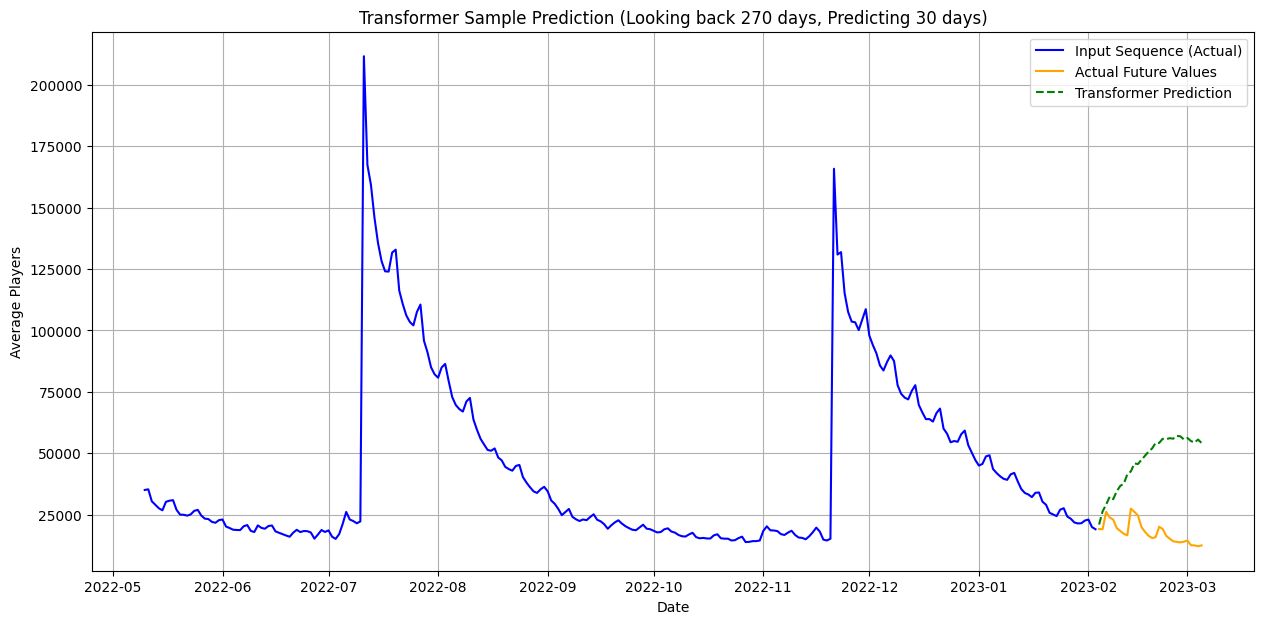


--- Performing Iterative Multi-Step Forecast Evaluation on Test Set ---

Overall RMSE for Iterative Multi-Step Forecast on Test Set: 30996.0778


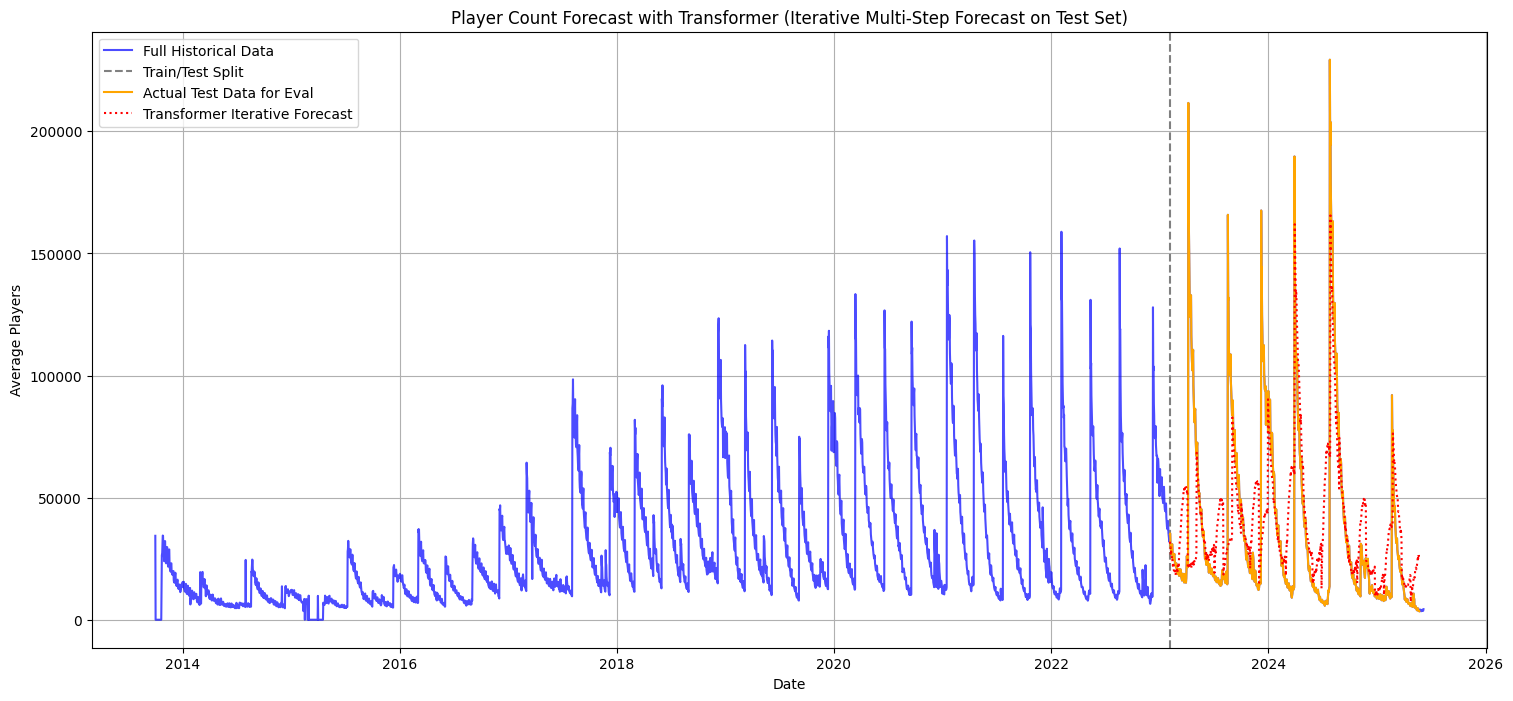


--- Performing Future Forecast ---

Forecast for the next 30 days:
2025-06-07: 6227.86
2025-06-08: 7635.22
2025-06-09: 9158.99
2025-06-10: 10380.73
2025-06-11: 11540.62
2025-06-12: 11116.91
2025-06-13: 12712.50
2025-06-14: 13892.85
2025-06-15: 13740.35
2025-06-16: 16000.37
2025-06-17: 17062.30
2025-06-18: 18296.00
2025-06-19: 17153.85
2025-06-20: 18429.58
2025-06-21: 18872.45
2025-06-22: 20121.32
2025-06-23: 20204.00
2025-06-24: 20300.02
2025-06-25: 21839.57
2025-06-26: 21518.20
2025-06-27: 21683.58
2025-06-28: 22612.10
2025-06-29: 23581.21
2025-06-30: 23780.47
2025-07-01: 24444.53
2025-07-02: 24918.18
2025-07-03: 24151.15
2025-07-04: 24477.97
2025-07-05: 24747.80
2025-07-06: 25058.39


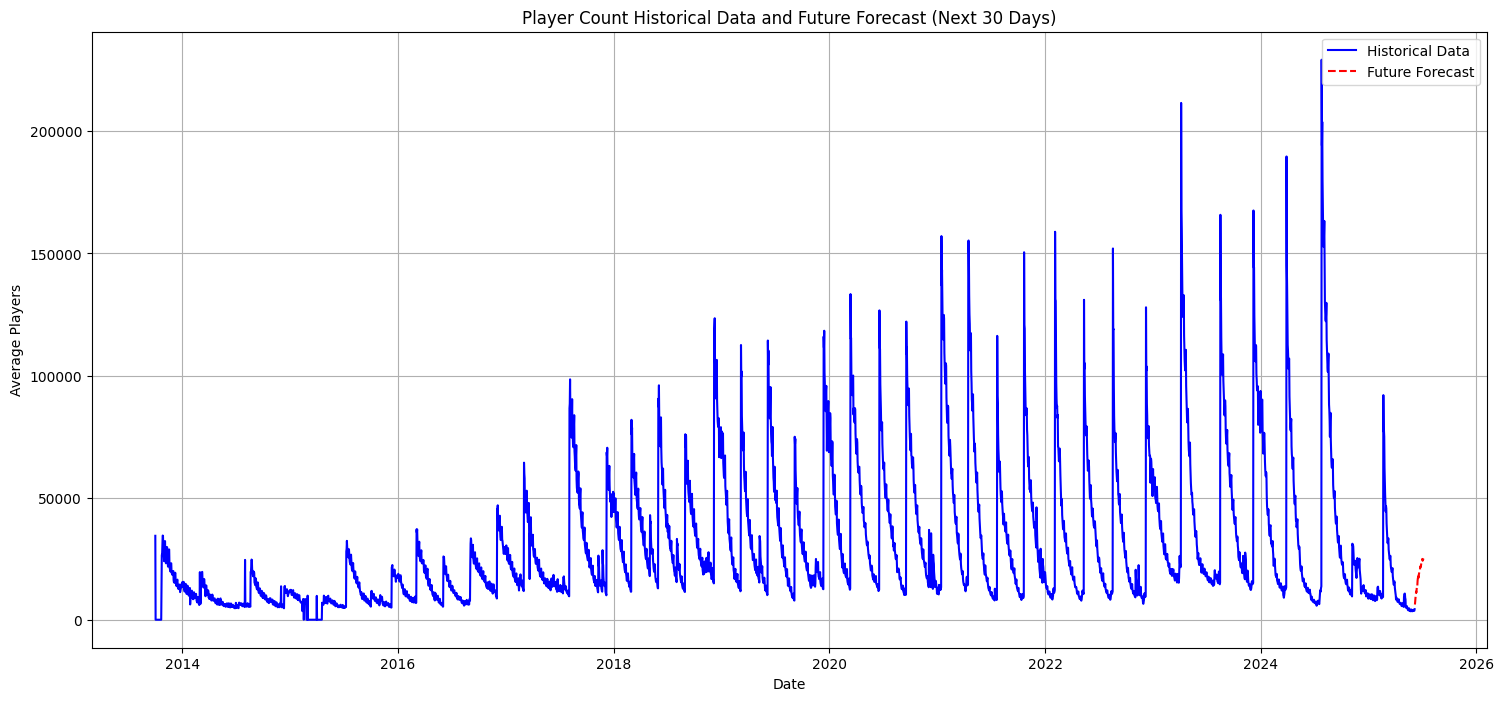

In [ ]:
# --- 4. Prediction and Evaluation ---

# --- Visualize a sample prediction vs actual ---
# Get one batch from the test loader
test_iter = iter(test_loader)
first_test_batch_X, first_test_batch_y = next(test_iter)

# Make prediction
model.eval()
with torch.no_grad():
    sample_pred_scaled_tensor = model(first_test_batch_X[:1]) # Take the first sample from the batch
    # FIX: Add .detach() before .cpu().numpy()
    sample_pred_scaled = sample_pred_scaled_tensor.detach().cpu().numpy().flatten()

# No change needed for actuals as they come from DataLoader and don't require grad here
sample_actual_scaled = first_test_batch_y[0].cpu().numpy().flatten()

# Inverse scale the predictions and actual values
sample_pred_rescaled = scaler.inverse_transform(sample_pred_scaled.reshape(-1, 1)).flatten()
sample_actual_rescaled = scaler.inverse_transform(sample_actual_scaled.reshape(-1, 1)).flatten()

# Calculate RMSE for this sample prediction
rmse_sample = np.sqrt(mean_squared_error(sample_actual_rescaled, sample_pred_rescaled))
print(f"\nSample RMSE for a single {PREDICTION_LENGTH}-day prediction: {rmse_sample:.4f}")

plt.figure(figsize=(15, 7))
# Find the start date for the first test sequence for plotting
input_seq_start_idx = len(players_ts) - len(test_data_scaled) - SEQUENCE_LENGTH
input_seq_end_idx = len(players_ts) - len(test_data_scaled)
input_seq_dates = players_ts.index[input_seq_start_idx : input_seq_end_idx]
input_seq_actual_rescaled = scaler.inverse_transform(X_test[0].reshape(-1, 1)).flatten() # X_test[0] is the first input sequence

plt.plot(input_seq_dates, input_seq_actual_rescaled, label='Input Sequence (Actual)', color='blue')

# Dates for the actual future values (from the start of the test set)
actual_future_start_idx = len(players_ts) - len(test_data_scaled)
actual_future_end_idx = actual_future_start_idx + PREDICTION_LENGTH
actual_future_dates = players_ts.index[actual_future_start_idx : actual_future_end_idx]
plt.plot(actual_future_dates, sample_actual_rescaled, label='Actual Future Values', color='orange')

# Plot the predicted future values
plt.plot(actual_future_dates, sample_pred_rescaled, label='Transformer Prediction', color='green', linestyle='--')

plt.title(f'Transformer Sample Prediction (Looking back {SEQUENCE_LENGTH} days, Predicting {PREDICTION_LENGTH} days)')
plt.xlabel('Date')
plt.ylabel('Average Players')
plt.legend()
plt.grid(True)
plt.show()


# --- Full Test Set Evaluation (Iterative Forecasting) ---
print("\n--- Performing Iterative Multi-Step Forecast Evaluation on Test Set ---")
all_test_predictions_iterative = []
all_test_actuals_iterative = []

current_input_sequence = train_data_scaled[-SEQUENCE_LENGTH:].copy()

for i in range(0, len(test_data_scaled) - PREDICTION_LENGTH + 1, PREDICTION_LENGTH):
    input_tensor = torch.tensor(current_input_sequence, dtype=torch.float32).reshape(1, SEQUENCE_LENGTH, 1).to(DEVICE)

    with torch.no_grad():
        # FIX: Add .detach() before .cpu().numpy()
        predicted_next_steps_scaled = model(input_tensor).detach().cpu().numpy().flatten() # (PREDICTION_LENGTH,)

    all_test_predictions_iterative.extend(predicted_next_steps_scaled)
    actual_segment = test_data_scaled[i : i + PREDICTION_LENGTH].flatten()
    all_test_actuals_iterative.extend(actual_segment)

    if i + PREDICTION_LENGTH < len(test_data_scaled):
        current_input_sequence = np.append(
            current_input_sequence[PREDICTION_LENGTH:],
            test_data_scaled[i : i + PREDICTION_LENGTH]
        )
    else:
        break


# Inverse scale the full iterative predictions and the actual test data
full_test_predictions_rescaled = scaler.inverse_transform(np.array(all_test_predictions_iterative).reshape(-1, 1)).flatten()
actual_test_data_rescaled_for_eval = scaler.inverse_transform(np.array(all_test_actuals_iterative).reshape(-1, 1)).flatten()


# Calculate overall RMSE for the iterative forecast
rmse_overall_iterative = np.sqrt(mean_squared_error(actual_test_data_rescaled_for_eval, full_test_predictions_rescaled))
print(f'\nOverall RMSE for Iterative Multi-Step Forecast on Test Set: {rmse_overall_iterative:.4f}')

# Plotting the full iterative forecast
plt.figure(figsize=(18, 8))
plt.plot(players_ts.index, players_ts, label='Full Historical Data', color='blue', alpha=0.7)

train_end_date = players_ts.index[3412]
test_start_date = players_ts.index[3413]
plt.axvline(train_end_date, color='grey', linestyle='--', label='Train/Test Split')

actual_test_dates_for_eval = players_ts.index[len(players_ts) - len(test_data_scaled) : len(players_ts) - len(test_data_scaled) + len(actual_test_data_rescaled_for_eval)]
plt.plot(actual_test_dates_for_eval, actual_test_data_rescaled_for_eval, label='Actual Test Data for Eval', color='orange')

predicted_test_dates_for_eval = players_ts.index[len(players_ts) - len(test_data_scaled) : len(players_ts) - len(test_data_scaled) + len(full_test_predictions_rescaled)]
plt.plot(predicted_test_dates_for_eval, full_test_predictions_rescaled, label='Transformer Iterative Forecast', color='red', linestyle=':')

plt.title('Player Count Forecast with Transformer (Iterative Multi-Step Forecast on Test Set)')
plt.xlabel('Date')
plt.ylabel('Average Players')
plt.legend()
plt.grid(True)
plt.show()


# --- 5. Future Forecasting ---
print("\n--- Performing Future Forecast ---")
future_forecast_input = scaled_data[-SEQUENCE_LENGTH:].copy()

future_predictions_scaled = []
with torch.no_grad():
    input_tensor = torch.tensor(future_forecast_input, dtype=torch.float32).reshape(1, SEQUENCE_LENGTH, 1).to(DEVICE)
    # FIX: Add .detach() before .cpu().numpy()
    predicted_future_values = model(input_tensor).detach().cpu().numpy().flatten() # (PREDICTION_LENGTH,)
    future_predictions_scaled.extend(predicted_future_values)

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

last_historical_date = players_ts.index[-1]
future_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=PREDICTION_LENGTH, freq='D')

print(f"\nForecast for the next {PREDICTION_LENGTH} days:")
for date, val in zip(future_dates, future_predictions_rescaled):
    print(f"{date.strftime('%Y-%m-%d')}: {val:.2f}")

plt.figure(figsize=(18, 8))
plt.plot(players_ts.index, players_ts, label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions_rescaled, label='Future Forecast', color='red', linestyle='--')
plt.title(f'Player Count Historical Data and Future Forecast (Next {PREDICTION_LENGTH} Days)')
plt.xlabel('Date')
plt.ylabel('Average Players')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

# --- 0. Configuration and Hyperparameters ---
# You can tune these
SEQUENCE_LENGTH = 270 # Look back 2 seasonal periods (180 days)
PREDICTION_LENGTH = 30 # Predict the next 30 days
BATCH_SIZE = 32
NUM_EPOCHS = 400 # Can increase if not converging, but monitor for overfitting
LEARNING_RATE = 1e-5
NUM_HEADS = 1 # Number of attention heads in Transformer
NUM_ENCODER_LAYERS = 1 # Number of Transformer Encoder layers
DIM_MODEL = 64 # Dimension of the hidden layers in Transformer
DIM_FEEDFORWARD = 256 # Dimension of the feedforward network in Transformer
DROPOUT = 0.5 # Dropout rate

best_test_loss = float('inf')
patience = 30 # Number of epochs to wait for improvement
patience_counter = 0
# Add a variable to store the best model's state_dict
best_model_state = None

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)


# Convert Polars DataFrame to Pandas Series and set DateTime as index
players_ts = players_daily_df.to_pandas().set_index('DateTime')['Players'].astype(float)
players_ts = players_ts.asfreq('D') # Ensure daily frequency, fill gaps if any
players_ts = players_ts.ffill().bfill() # Fill any NaNs

print(f"Full time series length: {len(players_ts)}")

# --- Scale Data ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(players_ts.values.reshape(-1, 1))

# Split the data based on your provided sizes (training: 3413, testing: 854)
# This means the last 854 points are for testing
train_data_scaled = scaled_data[:3413]
test_data_scaled = scaled_data[3413:]

print(f"Scaled training data shape: {train_data_scaled.shape}")
print(f"Scaled testing data shape: {test_data_scaled.shape}")

# Function to create sequences for Transformer
def create_sequences(data, seq_length, pred_length):
    xs, ys = [], []
    # Loop needs to ensure there's enough data for both input sequence and prediction length
    # i + seq_length + pred_length must be <= len(data)
    for i in range(len(data) - seq_length - pred_length + 1):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + pred_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


X_train, y_train = create_sequences(train_data_scaled, SEQUENCE_LENGTH, PREDICTION_LENGTH)
X_test, y_test = create_sequences(test_data_scaled, SEQUENCE_LENGTH, PREDICTION_LENGTH)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1).to(DEVICE) # Squeeze to (batch, pred_len)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1).to(DEVICE) # Squeeze to (batch, pred_len)


print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- 2. Transformer Model Definition ---

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, dim_model, num_heads, num_encoder_layers, dim_feedforward, dropout, max_seq_len):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads,
                                                       dim_feedforward=dim_feedforward, dropout=dropout,
                                                       batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.input_linear = nn.Linear(input_dim, dim_model)
        # The output_linear now projects from dim_model (from the last token's representation) to PREDICTION_LENGTH
        self.output_linear = nn.Linear(dim_model, output_dim)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.rand(1, max_seq_len, dim_model)) # Max seq len for PE

    def forward(self, src):
        # src shape: (batch_size, sequence_length, input_dim)

        # 1. Linear projection for input features
        src = self.input_linear(src) # (batch_size, sequence_length, dim_model)

        # 2. Add positional encoding
        seq_len = src.size(1)
        if seq_len > self.positional_encoding.size(1):
            raise ValueError(f"Sequence length {seq_len} exceeds max positional encoding length {self.positional_encoding.size(1)}. Adjust max_seq_len in model init.")
        src = src + self.positional_encoding[:, :seq_len, :] # (batch_size, sequence_length, dim_model)

        # 3. Pass through Transformer Encoder
        output = self.transformer_encoder(src) # (batch_size, sequence_length, dim_model)

        # 4. Take the output of the last token in the sequence for prediction
        # Shape: (batch_size, dim_model)
        last_token_output = output[:, -1, :]

        # 5. Project the last token's output to the desired prediction length
        # Shape: (batch_size, PREDICTION_LENGTH)
        predictions = self.output_linear(last_token_output)

        return predictions


# Initialize the model with max_seq_len for positional encoding
# Use SEQUENCE_LENGTH as max_seq_len since that's our fixed input sequence length
model = TimeSeriesTransformer(
    input_dim=1, # Number of features (player count)
    output_dim=PREDICTION_LENGTH, # Predict PREDICTION_LENGTH values
    dim_model=DIM_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    max_seq_len=SEQUENCE_LENGTH # Pass max_seq_len for positional encoding
).to(DEVICE)

print(f"\nModel architecture:\n{model}")
print(f"Total model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


# --- 3. Training Loop ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

print("\n--- Starting Model Training ---")
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y) # batch_y is already (batch, pred_len)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation/Testing Phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_X_test, batch_y_test in test_loader:
            predictions_test = model(batch_X_test)
            loss_test = criterion(predictions_test, batch_y_test) # batch_y_test is already (batch, pred_len)
            total_test_loss += loss_test.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0 # Reset patience
        # Save the best model state
        best_model_state = model.state_dict()
    else:
        patience_counter += 1 # Increment patience
        print(f"Patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"Early stopping at Epoch {epoch+1} due to no improvement in test loss.")
        break

    if (epoch + 1) % 10 == 0 or epoch == 1: # Print first epoch as well
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')

print("\n--- Training Complete ---")

if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model state based on lowest test loss.")
else:
    print("No best model state saved (perhaps training finished too quickly or initial loss was already lowest).")

# Plotting loss history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()